# CATE estimation with unconfounded data
Here, we explore the effectiveness of different scoring metrics in capturing the error between the estimated and true causal effects in small synthetic datasets.  
The data generating process simulates a randomised control trial in which covariates and treatment both affect the outcome, but treatment assignment is fully random.  

## Background
Often, different units are suceptible to a treatment to different degrees. Our goal is to use our toolbox to estimate these heterogenous treatment effects and assess how well the toolbox performs
In other words, how well does a score reflect the mismatch between the estimated and true causal effect?  
We divide our approach in different parts. First, we'll generate some synthetic data for which we know the relationship between variables, as well as the treatment effect. 
We'll consider two scenarios, with and without confounding variables. Next, we'll use AutoCausality for hyperparameter tuning and model selection of a zoo of causal estimators. We'll do this for different scoring methods.
Lastly, we'll plot the returned scores against the misestimation error between predicted and true treatment effect. 
Below, we import the relevant modules and define a few helper functions (TODO outsource the latter to autocausality, once approved)

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..
try:
    import graphviz
except ModuleNotFoundError as e:
    import pip
    pip.main(["install","graphviz"])
    import graphviz

from typing import Union

root_path = root_path = os.path.realpath('../../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from sklearn.model_selection import train_test_split
from auto_causality import AutoCausality
from auto_causality.data_utils import preprocess_dataset
from auto_causality.datasets import generate_synthetic_data


In [2]:
# set a few params
metrics = ["norm_erupt", "qini", "energy_distance"]
n_samples = 10000
test_size = 0.33 # equal train,val,test
components_time_budget = 20
estimator_list = "all"
n_runs = 1
out_dir = "../data/"
filename_out = "synthetic_rct_cate_24h" 


We will begin with a simple synthetic dataset, in which the outcome is influenced by the treatment and a set of covariates, which are independent of the treatment:

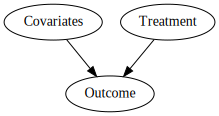

In [3]:
dot = graphviz.Digraph("causal-graph",comment="A simple causal graph",filename="rct_cate_graph.gv")
dot.node("X",label="Covariates")
dot.node("T",label="Treatment")
dot.node("Y",label="Outcome")
dot.edge("X","Y")
dot.edge("T","Y")
dot.edge_attr.update(arrowsize="1")
dot

### 1.1 Dataset generation

Let $X^{Nxd}$ be the matrix of $N$ observations and $d$ covariates, $T^{nx1}$ the vector of treatment assignments and $Y^{nx1}$ the vector of outcomes. 
We make the following assumptions:  
- binary treatments
- fully random propensity to treat (unconfoundedness)
- five continuous, normally distributed covariates
- no interaction between treatment effects and covariates 
- independence of the covariates, i.e. $\Sigma = \sigma^2I$
- no additive noise in the outcomes, i.e. $\epsilon=0$

  
Then, the data is generated according to the following equations:
\begin{align*}
& X_i \sim \mathcal{N}(0,\Sigma) \\\\
& T_i \sim Bernoulli(0.5) \\\\
& Y_i = \tau(X_i) T_i + \mu_0(X_i) + \epsilon
\end{align*}
where $i$ indexes individual units, $\tau$ describes the following true treatment effect, which depends linearly on all covariates:
\begin{equation*}
\tau(X_i) = X_ib^T + e
\end{equation*}
where $b$ is a 1xd vector of $b_i \sim U(0.4,0.7)$ weights for each covariate and $e \sim \mathcal{N}(0,0.05)$ gaussian noise.  
... and  $\mu_0(x)$ describes the following transformation of the covariates (to keep things interesting):
\begin{equation*}
\mu_0(X_i) = X_{i,1} \otimes X_{i,2} + X_{i,3} + X_{i,4} \otimes X_{i,5} 
\end{equation*}




### 1.2 Preprocessing
Now we apply AutoCausality's built-in preprocessing pipeline and construct train/val/test sets

In [9]:
dataset = generate_synthetic_data(n_samples=n_samples, confounding=False,noisy_outcomes=True)
data_df, features_X, features_W = preprocess_dataset(
    dataset.data, treatment=dataset.treatment, targets=dataset.outcomes
)
# drop true effect:
features_X = [f for f in features_X if f != "true_effect"]
print(f"features_X: {features_X}")
print(f"features_W: {features_W}")
data_df.head(10)



features_X: ['X1', 'X2', 'X3', 'X4', 'X5']
features_W: ['random']


### 1.3 Model fitting
Now we're ready to find the best fitting model, given a user-specified metric. As we'd like to compare different metrics, we'll be doing this in a for-loop

In [ ]:

for i_run in range(1,n_runs+1):

    train_df, test_df = train_test_split(data_df, test_size=test_size)
    test_df = test_df.reset_index(drop=True)
    
    for metric in metrics:
        try:
            ac = AutoCausality(
                metric=metric,
                verbose=1,
                components_verbose=1,
                components_time_budget=components_time_budget,
                estimator_list=estimator_list,
                store_all_estimators=True,
            )

            ac.fit(
                train_df,
                treatment="treatment",
                outcome="outcome",
                common_causes=features_W,
                effect_modifiers=features_X,
            )
            
            # compute relevant scores (skip newdummy)
            datasets = {"train": ac.train_df, "validation": ac.test_df, "test": test_df}
            # get scores on train,val,test for each trial, 
            # sort trials by validation set performance
            # assign trials to estimators
            estimator_scores = {est: [] for est in ac.scores.keys() if "NewDummy" not in est}
            for trial in ac.results.trials:
                # estimator name:
                estimator_name = trial.last_result["estimator_name"]
                if  trial.last_result["estimator"]:
                    estimator = trial.last_result["estimator"]
                    scores = {}
                    for ds_name, df in datasets.items():
                        scores[ds_name] = {}
                        # make scores
                        est_scores = ac.scorer.make_scores(
                            estimator,
                            df,
                            problem=ac.problem,
                            metrics_to_report=ac.metrics_to_report,
                        )

                        # add cate:
                        scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
                        # add ground truth for convenience
                        scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
                        scores[ds_name][metric] = est_scores[metric]
                    estimator_scores[estimator_name].append(scores)


            # sort trials by validation performance
            for k in estimator_scores.keys():
                estimator_scores[k] = sorted(
                    estimator_scores[k],
                    key=lambda x: x["validation"][metric],
                    reverse=False if metric == "energy_distance" else True,
                )
            results = {
                "best_estimator": ac.best_estimator,
                "best_config": ac.best_config,
                "best_score": ac.best_score,
                "optimised_metric": metric,
                "scores_per_estimator": estimator_scores,
            }


            with open(f"{out_dir}{filename_out}_{metric}_run_{i_run}.pkl", "wb") as f:
                pickle.dump(results, f)
        except:
            pass



### 1.4 Evaluation
How well did the different metrics quantify the mismatch between estimated and true treatment effects?

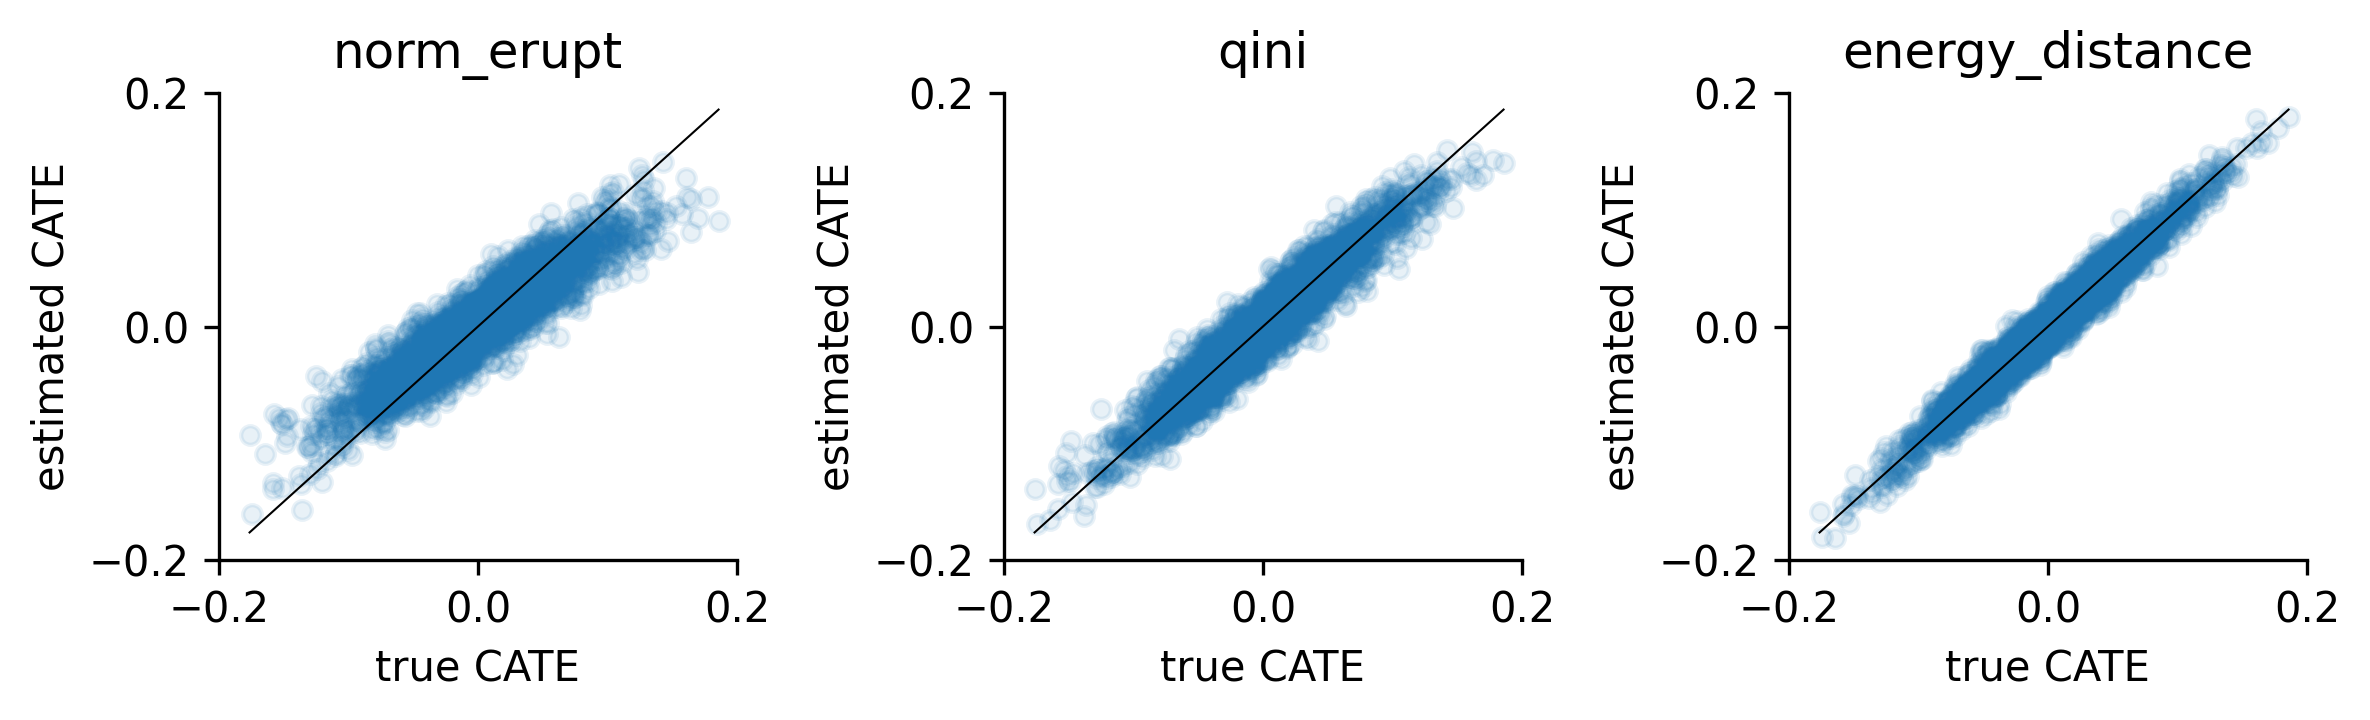

In [19]:
%matplotlib inline
f, axs = plt.subplots(1,len(metrics),figsize=(8,2.5),dpi=300)


# plot true against estimated for best estimator:
for ax, metric in zip(axs, metrics):
    with open(f"{out_dir}{filename_out}_{metric}_run_1.pkl","rb") as f:
        results = pickle.load(f)
    CATE_gt = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_groundtruth"]
    CATE_est = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_estimate"]
    

    ax.scatter(CATE_gt,CATE_est,s=20,alpha=0.1)
    
    ax.plot([min(CATE_gt),max(CATE_gt)],[min(CATE_gt),max(CATE_gt)],"k-",linewidth=0.5)
    ax.set_xlabel("true CATE")
    ax.set_ylabel("estimated CATE")
    ax.set_title(f"{results['optimised_metric']}")
    ax.set_xlim([-0.2,0.2])
    ax.set_ylim([-0.2,0.2])
    ax.set_xticks(np.arange(-0.2,0.21,0.2))
    ax.set_yticks(np.arange(-0.2,0.21,0.2))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout() 
plt.savefig(f"paper_{filename_out}_mse.pdf",format="pdf")

now plot the score against the mse between estimated and true cate for each of the models in the scores dict

In [5]:
import colorsys

def scale_lightness(rgb, scale_l):
    # found here https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

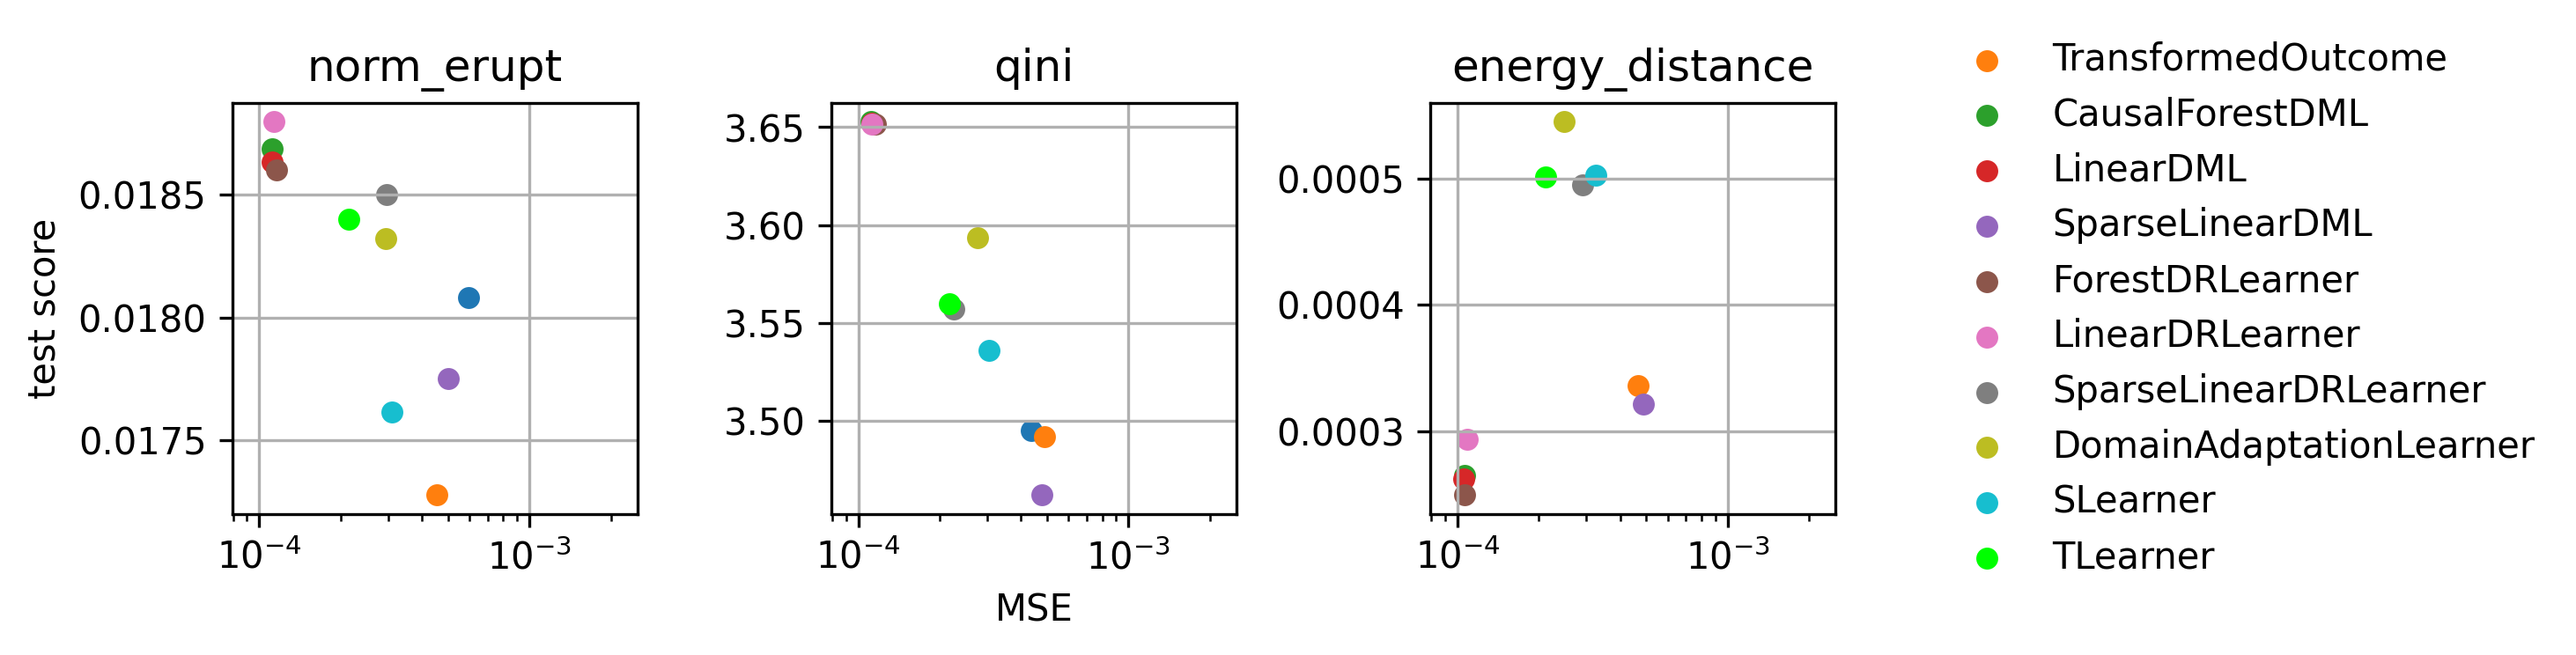

In [34]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])

plt.figure(figsize=(10,2.5),dpi=300)
# f, axs = plt.subplots(1,len(metrics),)

est_labels = [[], [], []]
sc = [[], [], []]
for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    with open(f"{out_dir}{filename_out}_{metric}_run_1.pkl","rb") as f:
        results = pickle.load(f)
    
    for (est_name, scr), col in zip(results["scores_per_estimator"].items(),colors): 
        if "Dummy" not in est_name:
            if len(scr):
                # also plot intermediate runs:
#                 if len(scr) > 1:
#                     print(f"{est_name}: {len(scr)} intermediate runs ")
#                     lightness = np.linspace(1,2.8,len(scr))
                    
#                     col_rgb = matplotlib.colors.ColorConverter.to_rgb(col)
#                     for i_run in range(1,len(scr)):
#                         CATE_gt = scr[i_run]["test"]["CATE_groundtruth"]
#                         CATE_est = scr[i_run]["test"]["CATE_estimate"]
#                         mse=np.mean((CATE_gt-CATE_est)**2)
#                         score = scr[i_run]["test"][metric]
#                         plt.scatter(mse,score,color=scale_lightness(col_rgb,lightness[i_run-1]),s=30,linewidths=0.5, label="_nolegend_" )
                # get score for best estimator:
                CATE_gt = scr[0]["test"]["CATE_groundtruth"]
                CATE_est = scr[0]["test"]["CATE_estimate"]
                mse=np.mean((CATE_gt-CATE_est)**2)
                score = scr[0]["test"][metric]
                plt.scatter(mse,score,color=col,s=30,linewidths=0.5)
                est_labels[i].append(est_name.split(".")[-1])
    if i is 1:
        plt.xlabel("MSE")    
    if i is 0:
        plt.ylabel("test score") 
    plt.title(metric)
    plt.xscale("log")    
    plt.xlim(10**-4.1,10**-2.6)
    plt.grid(True)
    
plt.legend(est_labels[0],loc='center left', bbox_to_anchor=(1.2, 0.5),frameon=False)
plt.tight_layout()
plt.savefig(f"paper_{filename_out}_scores.pdf",format="pdf")
plt.show()

In [8]:
results

{'best_estimator': 'backdoor.econml.dr.LinearDRLearner',
 'best_config': {'estimator': {'estimator_name': 'backdoor.econml.dr.LinearDRLearner',
   'fit_cate_intercept': 0,
   'min_propensity': 0.0016180247592266024}},
 'best_score': 0.0003932302253254194,
 'optimised_metric': 'energy_distance',
 'scores_per_estimator': {'backdoor.auto_causality.models.Dummy': [],
  'backdoor.auto_causality.models.TransformedOutcome': [],
  'backdoor.econml.dml.CausalForestDML': [{'train': {'CATE_estimate': array([ 0.04218144,  0.03384756,  0.01251613, ..., -0.00537728,
             0.07056947,  0.0243593 ]),
     'CATE_groundtruth': 7142    0.033522
     8807    0.026716
     808     0.023165
     2159    0.035416
     3848    0.063729
               ...   
     7947   -0.007334
     3063   -0.033198
     7181   -0.015306
     1920    0.059522
     2805    0.019531
     Name: true_effect, Length: 5360, dtype: float32,
     'energy_distance': 0.0001857967142476491},
    'validation': {'CATE_estimate': a